# Analyze workflow traces

In [1]:
import geoengine as ge

from datetime import datetime
import re
import pandas as pd
import matplotlib.pyplot as plt

## Define some complex workflow

In [2]:
workflow = {
	"type": "Vector",
	"operator": {
		"type": "PointInPolygonFilter",
		"params": {},
		"sources": {
			"points": {
				"type": "RasterVectorJoin",
				"params": {
					"names": ["Temporal Aggregation of NDVI", "Land Cover"],
					"featureAggregation": "first",
					"temporalAggregation": "none"
				},
				"sources": {
					"vector": {
						"type": "OgrSource",
						"params": {
							"data": {
								"type": "internal",
								"datasetId": "a9623a5b-b6c5-404b-bc5a-313ff72e4e75"
							},
							"attributeProjection": None,
							"attributeFilters": None
						}
					},
					"rasters": [{
						"type": "TemporalRasterAggregation",
						"params": {
							"aggregation": {
								"type": "mean",
								"ignoreNoData": False
							},
							"window": {
								"granularity": "months",
								"step": 2
							},
							"windowReference": None,
							"outputType": None
						},
						"sources": {
							"raster": {
								"type": "GdalSource",
								"params": {
									"data": {
										"type": "internal",
										"datasetId": "36574dc3-560a-4b09-9d22-d5945f2b8093"
									}
								}
							}
						}
					}, {
						"type": "GdalSource",
						"params": {
							"data": {
								"type": "internal",
								"datasetId": "9ee3619e-d0f9-4ced-9c44-3d407c3aed69"
							}
						}
					}]
				}
			},
			"polygons": {
				"type": "OgrSource",
				"params": {
					"data": {
						"type": "internal",
						"datasetId": "b6191257-6d61-4c6b-90a4-ebfb1b23899d"
					},
					"attributeProjection": None,
					"attributeFilters": None
				}
			}
		}
	},
}
	

## Run the workflow

In [3]:
ge.initialize("http://localhost:3030/api")

ports = ge.register_workflow(workflow)

time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

df = ports.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
        ge.TimeInterval(time, time),
        ge.SpatialResolution(0.1, 0.1)
        )
)

## Analyze the traces

In [4]:
LOG_FILE_PATH = "../../geoengine/geo_engine_rCURRENT.log"

## Define some helper functions

In [5]:
datetime_pattern = r"\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{6}Z"
id_pattern = r'OperatorWorkflowPath: \[([\d,\s]*)\]'

def parse_initialize(line):
    # Extract datetime, operator name, and id number

    # TODO: also capture workflow execution id once it is available
    
    operator_pattern = r'Initialize (.+?),'   

    datetime_match = re.search(datetime_pattern, line)
    operator_match = re.search(operator_pattern, line)
    id_match = re.search(id_pattern, line)

    if datetime_match and operator_match and id_match:
        return datetime_match.group(0), operator_match.group(1), id_match.group(1)
    else:
        return None
    
def parse_poll_next(line):
    # Extract datetime, operator name, and id number

    # TODO: also capture workflow execution id once it is available
    poll_next_count_pattern = r'poll_next_count=(\d+)'
    element_count_pattern = r'element_count=(\d+)'
    empty_pattern = r'empty=(\w+)'

    datetime_match = re.search(datetime_pattern, line)
    id_match = re.search(id_pattern, line)
    poll_next_count_match = re.search(poll_next_count_pattern, line)
    element_count_match = re.search(element_count_pattern, line)
    empty_match = re.search(empty_pattern, line)

    if datetime_match and id_match and poll_next_count_match and element_count_match and empty_match:
        return datetime_match.group(0), id_match.group(1), poll_next_count_match.group(1), element_count_match.group(1), empty_match.group(1)
    else:
        return None
    
def parse_query(line):
    # Extract datetime, operator name, and id number

    # TODO: also capture workflow execution id once it is available
    query_pattern = r'query_count=(\d+)'

    datetime_match = re.search(datetime_pattern, line)
    id_match = re.search(id_pattern, line)
    query_count_match = re.search(query_pattern, line)

    if datetime_match and id_match and query_count_match:
        return datetime_match.group(0), id_match.group(1), query_count_match.group(1)
    else:
        return None

## Parse the log file and collect some data

In [6]:
# TODO: process each workflow run separately

operators = {}

poll_data = []

query_data = []

with open(LOG_FILE_PATH, "r") as file:
    for line in file:
        if "Initialize" in line:
            parsed_data = parse_initialize(line)
            if parsed_data:
                datetime, operator, id_number = parsed_data

                operators[id_number] = operator
                # print(f"Initialize: datetime: {datetime}, operator: {operator}, id: {id_number}")

        if 'event="poll_next"' in line:
            parsed_data = parse_poll_next(line)
            if parsed_data:
                datetime, id, poll_next_count, element_count, empty = parsed_data
                    
                # print(f"Poll next: datetime: {datetime}, id: {id}, poll_next_count: {poll_next_count}, element_count: {element_count}")

                if empty == "false":
                    poll_data.append({
                        "datetime": datetime,
                        "operator": f"{operators[id]} ({id})",
                        "element_count": 1, # int(element_count),
                    })

        if 'query_count=' in line:
            parsed_data = parse_query(line)

            if parsed_data:
                datetime, id, query_count = parsed_data

                query_data.append({
                    "datetime": datetime,
                    "operator": f"{operators[id]} ({id})",
                    "query_count": int(query_count),
                })  

## Plot the polls over time for all operators

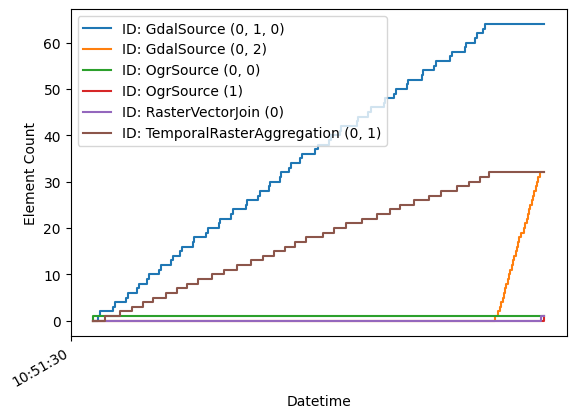

In [7]:
poll_next_df = pd.DataFrame(poll_data)
poll_next_df['datetime'] = pd.to_datetime(poll_next_df['datetime'])

# Find the minimum and maximum datetime values
min_datetime = poll_next_df["datetime"].min()
max_datetime = poll_next_df["datetime"].max()

# Add an extra data point with the minimum and maximum datetime values and a count of 0 for each unique operator
unique_operators = poll_next_df["operator"].unique()
extra_data_min = pd.DataFrame([{"operator": operator, "datetime": min_datetime, "element_count": 0} for operator in unique_operators])
extra_data_max = pd.DataFrame([{"operator": operator, "datetime": max_datetime, "element_count": 0} for operator in unique_operators])

poll_next_df = pd.concat([extra_data_min, poll_next_df, extra_data_max])

poll_next_df.set_index('datetime', inplace=True)

poll_next_grouped = poll_next_df.groupby('operator')

for id_value, group in poll_next_grouped:
        group['element_count'].cumsum().plot(drawstyle='steps-post', label=f"ID: {id_value}")

plt.xlabel('Datetime')
plt.ylabel('Element Count')
plt.legend()
plt.show()


## Plot each operator separately

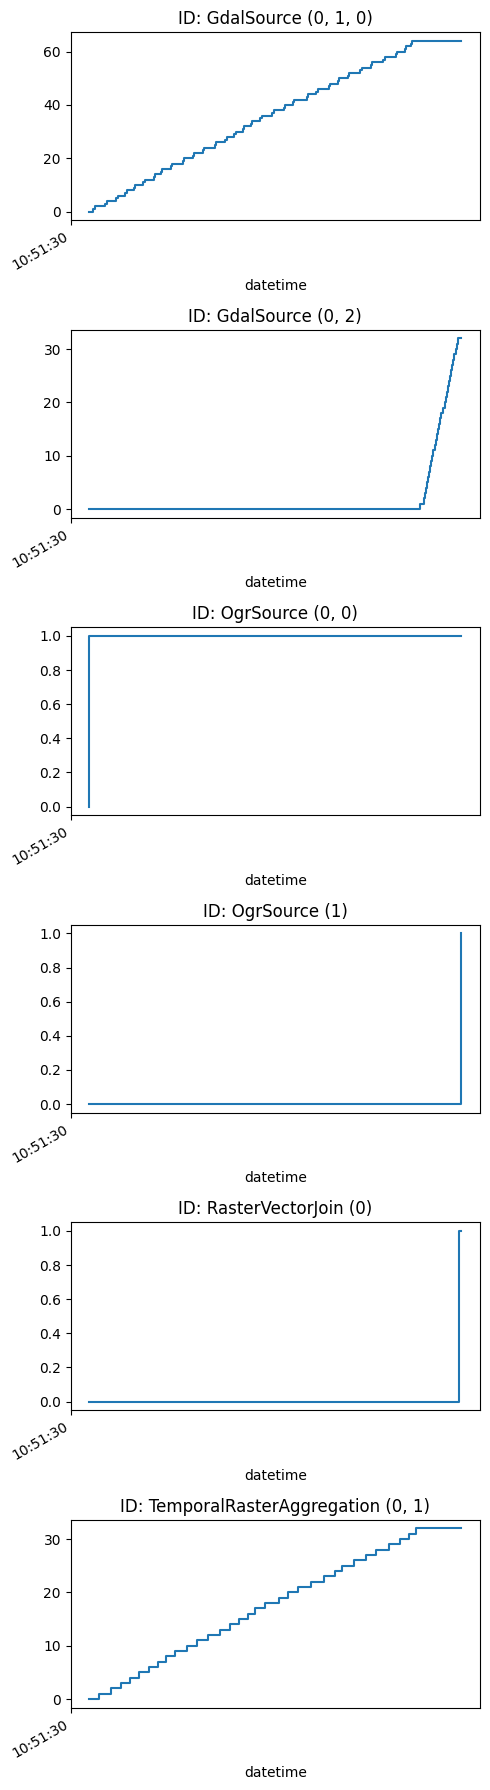

In [8]:
grouped = poll_next_df.groupby('operator')
num_ids = len(grouped)
plot_index = 1

plt.figure(figsize=(5, num_ids * 3))

for id_value, group in grouped:
    plt.subplot(num_ids, 1, plot_index)  # Create a new subplot for each id
    group['element_count'].cumsum().plot(drawstyle='steps-post')

    # Set up the plot
    plt.title(f"ID: {id_value}")
    plot_index += 1

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


## Plot the queries over time

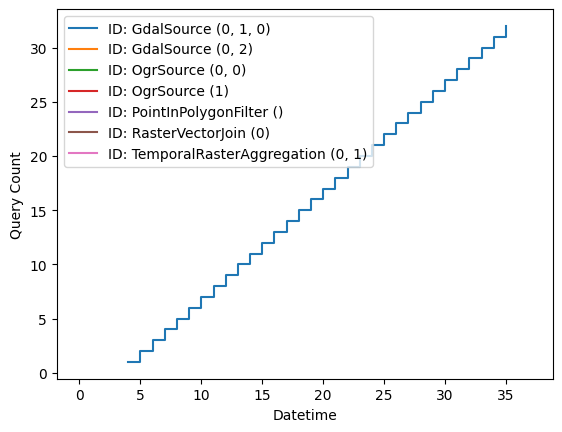

In [11]:
query_df = pd.DataFrame(query_data)
query_df['datetime'] = pd.to_datetime(query_df['datetime'])
# query_df.set_index('datetime', inplace=True)

grouped = query_df.groupby('operator')

for id_value, group in grouped:
        group['query_count'].plot(drawstyle='steps-post', label=f"ID: {id_value}")

plt.xlabel('Datetime')
plt.ylabel('Query Count')
plt.legend()
plt.show()

## Plot a graph with the final counts

In [12]:
# Group data by operator
grouped = poll_next_df.groupby('operator')

# Compute the final cumulative sum for the element_count column within each group
final_cumulative_element_counts = grouped['element_count'].sum()

# Get the total queries for each operator
query_counts = query_df.groupby('operator')["query_count"].last()

# Convert the final cumulative element counts to a list of dictionaries
result = [{"operator": operator, "element_count_sum": count} for operator, count in final_cumulative_element_counts.items()]

for item in result:
    item["query_count"] = query_counts[item["operator"]]

In [13]:
import networkx as nx

nodes = []
links = []

for item in result:
    operator = item['operator']
    path = operator[operator.find("(") + 1:operator.find(")")].split(", ")
    path = tuple(int(i) if i.isdigit() else None for i in path)

    nodes.append({"id": path, "name": operator.split(" ")[0]})

    if path == (None, ):
        continue

    parent = path[:-1]

    if len(parent) == 0:
        parent = (None, )

    links.append({"source": parent, "target": path, "element_count": item['element_count_sum'], "query_count": item['query_count']})

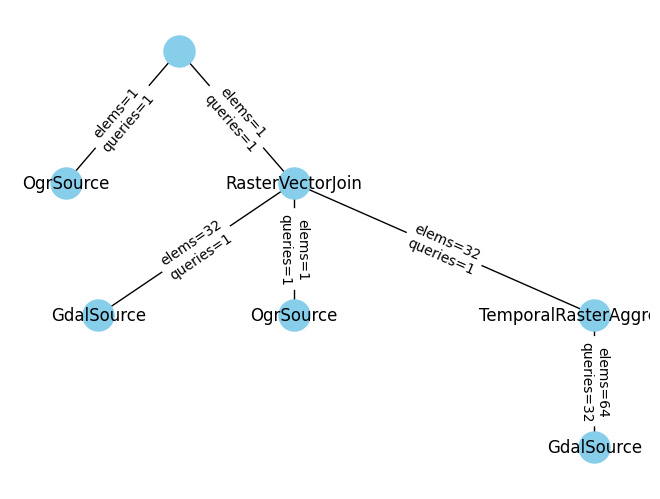

In [14]:
import networkx as nx

G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(node["id"], label=node["name"])

# Add edges to the graph
for link in links:
    G.add_edge(link["source"], link["target"], element_count=link["element_count"], query_count=link["query_count"])

# Define a layout for the graph (tree layout)
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="dot")

# Draw the graph
nx.draw(G, pos, with_labels=False, arrows=False, node_size=500, node_color="skyblue")

# Draw the node labels
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, labels=labels)

# Draw the edge labels
# Get edge attributes
element_count_labels = nx.get_edge_attributes(G, "element_count")
query_count_labels = nx.get_edge_attributes(G, "query_count")

# Combine the attributes to create edge labels
edge_labels = {k: f"elems={element_count_labels[k]}\nqueries={query_count_labels[k]}" for k in G.edges()}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.axis("off")
plt.show()